# Time-frequency analysis
This notebook re-analyzes and extracts power from the 
resting state???

- which method to use: Hilbert-filter, complex morlet wavelet convolution, Short-time FFT (Welch), Multitapers
- If we use Welch method what is the size of the fft window? should we have zero paddings? should we have overlap? what to do for the edge artefacts?
- Normalization: which method to use? Z transform, percentage change or decibels? which part of the recording should be used as the baseline? which baseline window is the best?

In [4]:
# setup
import mne
import numpy as np
import pandas as pd
import os.path as op
import matplotlib.pyplot as plt
import mne_bids
# from autoreject import get_rejection_threshold
# from preprocessing import _epochs_to_continuous, _make_montage
# from xarray_creator import _cut_noisy

# open preprocessed data
n_sub = '01'
task = 'induction1'
con_dict = {}
data_dir = 'data/clean_data'
'sub-01_ses-01_task-induction4_epo.fif'
epoch_name = f'sub-{n_sub}_ses-01_task-{task}_epo.fif'
dir = op.join(data_dir, epoch_name)

# open clean epochs
# epoch = mne.read_epochs(dir)
raw = mne.read_epochs(dir)

Reading /Users/yeganeh/Codes/otka-preprocessing/data/clean_data/sub-01_ses-01_task-induction1_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
270 matching events found
No baseline correction applied
0 projection items activated


In [8]:
from mne.time_frequency import psd_welch
psd, _ = psd_welch(raw, n_fft=1051, n_per_seg=1051, fmax=40)

Effective window size : 1.051 (s)


## The impact of different parameters on welch method
Below image shows is that if we use epoched data and then average over the epoch dimention is the same as we concatenate epochs and then calculate the psd using Welch method.

In [ ]:
bids_path = mne_bids.BIDSPath(subject='01', session='01', task='baseline1', root='data/BIDS_data')
raw = mne_bids.read_raw_bids(bids_path, verbose=False)
raw = _cut_noisy(raw, 'baseline1', 'hun')
raw.load_data().filter(0.5, 42, h_trans_bandwidth='auto')
pos = _make_montage()
raw.set_montage(pos)

epochs = mne.make_fixed_length_epochs(raw, duration=1)
reject = get_rejection_threshold(epochs)
epochs.drop_bad(reject=reject)
data = _epochs_to_continuous(epochs)
info = mne.create_info(ch_names=raw.ch_names, sfreq=1000, ch_types='eeg')
raw2 = mne.io.RawArray(data, info)
raw2.set_channel_types({'ECG':'ecg',
                       'EOG1':'eog',
                       'EOG2':'eog'})
raw2.set_montage(pos)
raw2.pick_types(eeg=True)

In [17]:
psds_welch_concatenated, freqs_median = psd_welch(raw, **kwargs)
psds_welch_concatenated = 10. * np.log10(psds_welch_concatenated)
psds_welch_concatenated = psds_welch_concatenated.mean(0)
psds_welch_concatenated

Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


array([[-121.54787559, -124.58502431, -126.19073461, ..., -128.78153257,
        -129.0155386 , -129.2597346 ],
       [-120.67487882, -124.10390873, -125.62990388, ..., -126.89432561,
        -127.05771763, -127.3329816 ],
       [-120.32561669, -123.53133484, -124.06361254, ..., -122.27862073,
        -122.66937986, -122.65986749],
       ...,
       [-118.10734077, -120.79237689, -122.1449324 , ..., -131.88907321,
        -132.67882032, -133.10121533],
       [-118.25247073, -121.603637  , -123.26744083, ..., -132.26924712,
        -133.58716617, -133.25898229],
       [-118.89900726, -121.51997543, -122.43463921, ..., -133.84260837,
        -133.995091  , -134.53661044]])

In [ ]:
kwargs = dict(fmin=2, fmax=40, n_jobs=-1, n_fft=1000, n_overlap=0)
psds_welch_epoch, freqs_mean = psd_welch(epochs, **kwargs)
psds_welch_epoch = psds_welch_epoch.mean(0)
psds_welch_concatenated, freqs_median = psd_welch(raw2, **kwargs)

# Convert power to dB scale.
psds_welch_epoch = 10 * np.log10(psds_welch_epoch)
psds_welch_concatenated = 10 * np.log10(psds_welch_concatenated)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'O1'
ch_idx = raw.info['ch_names'].index(ch_name)

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_epoch[ch_idx, :], color='k',
        ls='-', label='RAW')
ax.plot(freqs_median, psds_welch_concatenated[ch_idx, :], color='k',
        ls='--', label='CONCATENATED')

ax.set(title='Welch PSD ({})'.format(ch_name),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


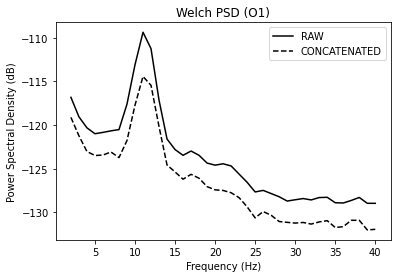

In [20]:
# examining the order of transformation and averaging

kwargs = dict(fmin=2, fmax=40, n_jobs=-1, n_fft=1000, n_overlap=0)
psds_welch_epoch, freqs_mean = psd_welch(raw, **kwargs)
psds_welch_epoch = psds_welch_epoch.mean(0)
psds_welch_epoch = 10. * np.log10(psds_welch_epoch)
psds_welch_concatenated, freqs_median = psd_welch(raw, **kwargs)
psds_welch_concatenated = 10. * np.log10(psds_welch_concatenated)
psds_welch_concatenated = psds_welch_concatenated.mean(0)

# We will only plot the PSD for a single sensor
ch_name = 'O1'
ch_idx = raw.info['ch_names'].index(ch_name)

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_epoch[ch_idx, :], color='k',
        ls='-', label='RAW')
ax.plot(freqs_median, psds_welch_concatenated[ch_idx, :], color='k',
        ls='--', label='CONCATENATED')

ax.set(title='Welch PSD ({})'.format(ch_name),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()